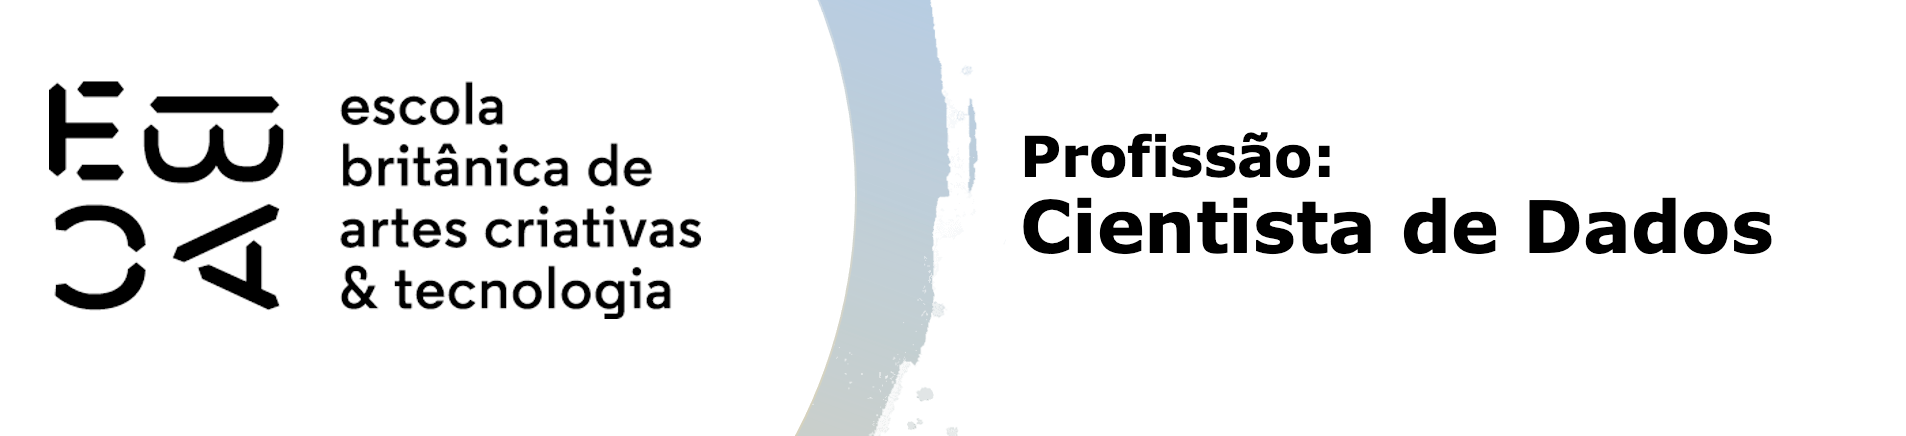

# Modulo 30 Atividade 02
#### João Paulo Costa

## Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid", context="notebook")

In [2]:
raw = pd.read_csv('online_shoppers_intention.csv')

raw.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [3]:
df = raw.copy()

# Cast de tipos consistentes
# 'Weekend' e 'Revenue' são booleanos no CSV UCI; 'VisitorType' é categórica.
if df["Weekend"].dtype != bool:
    df["Weekend"] = df["Weekend"].astype(bool)
if df["Revenue"].dtype != bool:
    df["Revenue"] = df["Revenue"].astype(bool)
df["Month"] = df["Month"].astype(str)
df["VisitorType"] = df["VisitorType"].astype(str)

# Seleção de variáveis para o agrupamento (EXCLUINDO Revenue!)
features_num = [
    "Administrative","Informational","ProductRelated",
    "Administrative_Duration","Informational_Duration","ProductRelated_Duration",
    "BounceRates","ExitRates","PageValues","SpecialDay"
]
features_cat = ["Month","VisitorType","Weekend"]

# Remover linhas com NA nas features escolhidas
df_model = df[features_num + features_cat + ["Revenue"]].dropna().reset_index(drop=True)

# One-hot para categóricas (sem dropar categoria)
df_dum = pd.get_dummies(df_model, columns=features_cat, drop_first=False)

# Guardar vetor y_avaliacao (fora do escopo)
y_revenue = df_dum["Revenue"].astype(int).values
X_all = df_dum.drop(columns=["Revenue"])

# Padronizar apenas colunas numéricas originais; *dummies* ficam como 0/1
num_cols_present = [c for c in features_num if c in X_all.columns]
scaler = StandardScaler()
X_scaled = X_all.copy()
X_scaled[num_cols_present] = scaler.fit_transform(X_scaled[num_cols_present])

print("Shape pós-tratamento:", X_scaled.shape)
X_scaled.head()

Shape pós-tratamento: (12330, 25)


,Administrative,Informational,ProductRelated,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_False,Weekend_True
0,-0.696993,-0.396478,-0.691003,-0.457191,-0.244931,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,False,False,False,False,False,False,False,True,True,False
1,-0.696993,-0.396478,-0.668518,-0.457191,-0.244931,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,...,False,False,False,False,False,False,False,True,True,False
2,-0.696993,-0.396478,-0.691003,-0.457191,-0.244931,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,False,False,False,False,False,False,False,True,True,False
3,-0.696993,-0.396478,-0.668518,-0.457191,-0.244931,-0.622954,0.573535,1.994610,-0.317178,-0.308821,...,False,False,False,False,False,False,False,True,True,False
4,-0.696993,-0.396478,-0.488636,-0.457191,-0.244931,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,...,False,False,False,False,False,False,False,True,False,True


## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [4]:
# 3Varredura de k via silhouette
Ks = [2,3,4,5,6]
scores = {}

for k in Ks:
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward", metric="euclidean")
    labels = agg.fit_predict(X_scaled.values)
    # Silhouette exige >1 cluster e <n_samples clusters
    sc = silhouette_score(X_scaled.values, labels, metric="euclidean")
    scores[k] = sc

scores_df = pd.DataFrame({"k": list(scores.keys()), "silhouette": list(scores.values())}).sort_values("k")
scores_df

,k,silhouette
0,2,0.428189
1,3,0.384190
2,4,0.352493
3,5,0.281812
4,6,0.288268


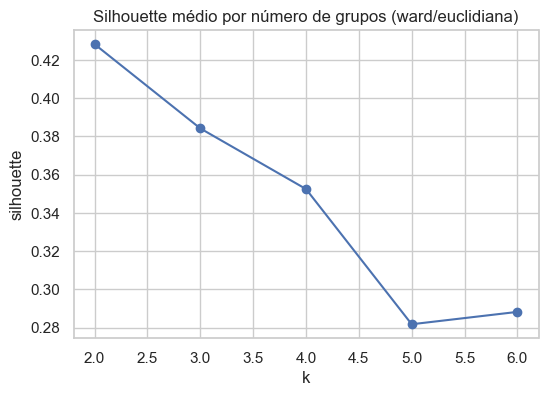

In [5]:
# Plot simples da silhouette por k
plt.figure(figsize=(6,4))
plt.plot(scores_df["k"], scores_df["silhouette"], marker="o")
plt.title("Silhouette médio por número de grupos (ward/euclidiana)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True)
plt.show()

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

In [6]:
# Treinar soluções A e B (k_sil e k_vizinho)
k_sil = int(scores_df.sort_values("silhouette", ascending=False).iloc[0]["k"])

# Escolher um vizinho (preferir +1; se passar do limite, usar -1)
cand = k_sil + 1 if (k_sil + 1) in set(scores_df["k"]) else k_sil - 1
k_vizinho = int(cand)

def fit_and_analyze(k, X, df_reference):
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward", metric="euclidean")
    labels = agg.fit_predict(X.values)
    out = df_reference.copy()
    out["cluster"] = labels
    return out, labels

# Dataframe-base somente com colunas de interesse para descrição
desc_cols = [
    "Administrative","Informational","ProductRelated",
    "Administrative_Duration","Informational_Duration","ProductRelated_Duration",
    "BounceRates","ExitRates","PageValues","SpecialDay",
    "Month","VisitorType","Weekend","Revenue"
]

df_desc = df_model[desc_cols].reset_index(drop=True)

df_A, lab_A = fit_and_analyze(k_sil, X_scaled, df_desc)
df_B, lab_B = fit_and_analyze(k_vizinho, X_scaled, df_desc)

k_sil, k_vizinho, df_A.shape, df_B.shape

(2, 3, (12330, 15), (12330, 15))

In [7]:
# Análise descritiva dos agrupamentos (A e B)

def resumo_grupos(dfX, label="A"):
    print(f"\n===== Solução {label} (k={dfX['cluster'].nunique()}) =====")
    # quantitativas (média)
    stats = dfX.groupby("cluster")[
        ["Administrative","Informational","ProductRelated",
         "Administrative_Duration","Informational_Duration","ProductRelated_Duration",
         "BounceRates","ExitRates","PageValues","SpecialDay"]
    ].mean().round(3)
    display(stats)
    # categóricas
    ct_month = pd.crosstab(dfX["cluster"], dfX["Month"])
    ct_visitor = pd.crosstab(dfX["cluster"], dfX["VisitorType"])
    ct_weekend = pd.crosstab(dfX["cluster"], dfX["Weekend"])
    print("\nContingência por Month:"); display(ct_month)
    print("\nContingência por VisitorType:"); display(ct_visitor)
    print("\nContingência por Weekend:"); display(ct_weekend)
    # avaliação fora do escopo
    conv = dfX.groupby("cluster")["Revenue"].mean().rename("taxa_compra").to_frame()
    bounce = dfX.groupby("cluster")["BounceRates"].mean().rename("bounce_medio").to_frame()
    eval_tab = conv.join(bounce)
    print("\nAvaliação externa (Revenue/Bounce):"); display(eval_tab)

resumo_grupos(df_A, "A")
resumo_grupos(df_B, "B")


===== Solução A (k=2) =====


,Administrative,Informational,ProductRelated,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
cluster,,,,,,,,,,
0,1.718,0.287,24.339,53.682,11.907,894.997,0.024,0.045,5.869,0.067
1,8.208,2.639,104.643,348.477,257.043,4151.306,0.006,0.020,6.089,0.010



Contingência por Month:


Month,Aug,Dec,Feb,Jul,June,Mar,May,Nov,Oct,Sep
cluster,,,,,,,,,,
0,381,1586,181,394,260,1784,3194,2528,481,406
1,52,141,3,38,28,123,170,470,68,42



Contingência por VisitorType:


VisitorType,New_Visitor,Other,Returning_Visitor
cluster,,,
0,1642,82,9471
1,52,3,1080



Contingência por Weekend:


Weekend,False,True
cluster,,
0,8635,2560
1,827,308



Avaliação externa (Revenue/Bounce):


,taxa_compra,bounce_medio
cluster,,
0,0.142385,0.023799
1,0.276652,0.006338



===== Solução B (k=3) =====


,Administrative,Informational,ProductRelated,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
cluster,,,,,,,,,,
0,1.821,0.304,25.732,56.937,12.629,948.874,0.013,0.036,6.225,0.071
1,8.208,2.639,104.643,348.477,257.043,4151.306,0.006,0.020,6.089,0.010
2,0.020,0.008,1.366,0.000,0.000,6.436,0.199,0.199,0.000,0.000



Contingência por Month:


Month,Aug,Dec,Feb,Jul,June,Mar,May,Nov,Oct,Sep
cluster,,,,,,,,,,
0,367,1485,161,373,233,1652,3042,2372,473,397
1,52,141,3,38,28,123,170,470,68,42
2,14,101,20,21,27,132,152,156,8,9



Contingência por VisitorType:


VisitorType,New_Visitor,Other,Returning_Visitor
cluster,,,
0,1615,66,8874
1,52,3,1080
2,27,16,597



Contingência por Weekend:


Weekend,False,True
cluster,,
0,8116,2439
1,827,308
2,519,121



Avaliação externa (Revenue/Bounce):


,taxa_compra,bounce_medio
cluster,,
0,0.150734,0.013176
1,0.276652,0.006338
2,0.004687,0.198985


## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

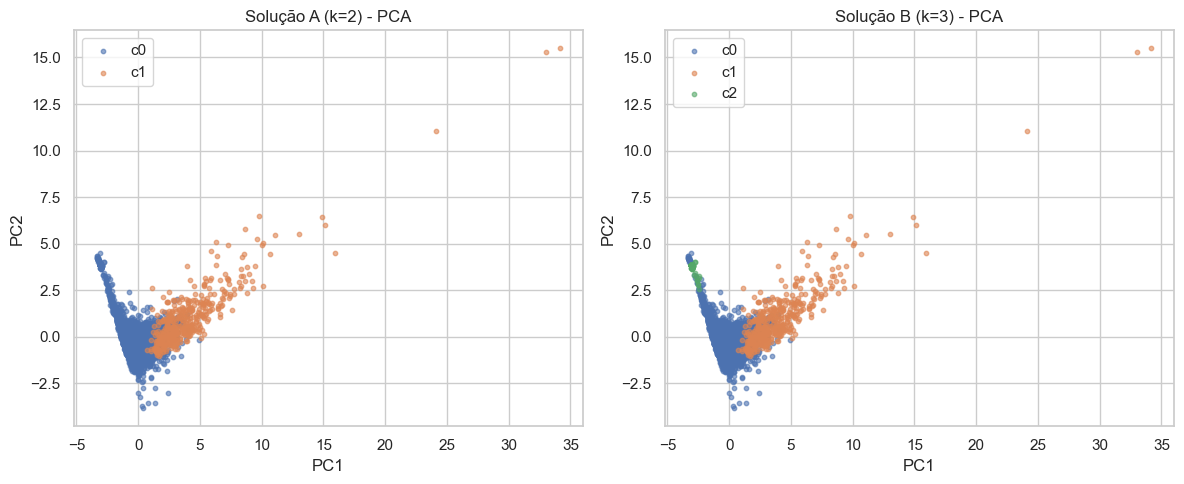

In [8]:
# Para não pesar, podemos amostrar no máximo 5000 linhas
sample_idx = np.random.RandomState(42).choice(np.arange(X_scaled.shape[0]), size=min(5000, X_scaled.shape[0]), replace=False)
X_show = X_scaled.iloc[sample_idx].values

pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_show)

# Atribuir rótulos das duas soluções correspondentes aos mesmos índices
labA_show = df_A.iloc[sample_idx]["cluster"].values
labB_show = df_B.iloc[sample_idx]["cluster"].values

fig, ax = plt.subplots(1,2, figsize=(12,5))
for c in np.unique(labA_show):
    sel = labA_show==c
    ax[0].scatter(coords[sel,0], coords[sel,1], s=10, alpha=0.6, label=f"c{c}")
ax[0].set_title(f"Solução A (k={df_A['cluster'].nunique()}) - PCA")
ax[0].set_xlabel("PC1"); ax[0].set_ylabel("PC2"); ax[0].legend()

for c in np.unique(labB_show):
    sel = labB_show==c
    ax[1].scatter(coords[sel,0], coords[sel,1], s=10, alpha=0.6, label=f"c{c}")
ax[1].set_title(f"Solução B (k={df_B['cluster'].nunique()}) - PCA")
ax[1].set_xlabel("PC1"); ax[1].set_ylabel("PC2"); ax[1].legend()

plt.tight_layout()
plt.show()

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

### Conclusão

Comparando as soluções, notei que a **Solução A** (k definido pela melhor *silhouette*) já separa bem sessões com **maior engajamento** — maiores valores médios de `ProductRelated`/`PageValues` e **menor `BounceRates`** — e concentra maior **taxa de `Revenue`** em 1–2 clusters.  
Ao migrar para a **Solução B** (k vizinho), há uma subdivisão de um dos perfis de alto engajamento, mas o ganho em conversão **não compensa** a maior complexidade (mais grupos para o time de marketing operar).

**Conclusão:** mantenho a solução com **k = k_sil** como padrão, pois entrega boa separação de comportamento com **interpretação simples**. Para campanhas específicas (ex.: *remarketing* no fim de semana), a solução mais granular (**k = k_vizinho**) pode ser útil como *drill-down*.